In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pylab import rcParams
from matplotlib.backends.backend_agg import FigureCanvasAgg
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold
from xgboost import XGBRegressor

plt.style.use('seaborn-darkgrid')

In [2]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [3]:
COVIDPovCount = pd.read_csv('COVIDpovertycount.csv',index_col = 0)
COVIDPovCount.head()

,State,cases,deaths,All Ages SAIPE Poverty Universe,All Ages in Poverty Count
0,Alabama,387786,14345,"4,763,811","801,758"
1,Alaska,18316,367,"720,866","80,224"
2,Arizona,426614,18857,"7,013,461","990,291"
3,Arkansas,161569,3301,"2,925,473","492,306"
4,California,2664110,102387,"38,818,530","4,972,955"


In [4]:
COVIDPovCount['All Ages SAIPE Poverty Universe'] = COVIDPovCount['All Ages SAIPE Poverty Universe'].str.replace(',', '').astype('int64')
COVIDPovCount['All Ages in Poverty Count'] = COVIDPovCount['All Ages in Poverty Count'].str.replace(',', '').astype('int64')

COVIDPovCount.head()

,State,cases,deaths,All Ages SAIPE Poverty Universe,All Ages in Poverty Count
0,Alabama,387786,14345,4763811,801758
1,Alaska,18316,367,720866,80224
2,Arizona,426614,18857,7013461,990291
3,Arkansas,161569,3301,2925473,492306
4,California,2664110,102387,38818530,4972955


In [5]:
COVIDPovCount = COVIDPovCount.drop(columns = ['cases', 'deaths'])
COVIDPovCount.head()

,State,All Ages SAIPE Poverty Universe,All Ages in Poverty Count
0,Alabama,4763811,801758
1,Alaska,720866,80224
2,Arizona,7013461,990291
3,Arkansas,2925473,492306
4,California,38818530,4972955


In [6]:
COVID = pd.read_csv('COVID.csv', index_col = 0)
COVID.head()

,State,cases,deaths
0,Alabama,26912,785
1,Alaska,751,10
2,Arizona,39298,1228
3,Arkansas,13191,188
4,California,159098,5202


In [7]:
COVIDPovCount = pd.merge(COVIDPovCount, COVID, how = 'left', on = 'State')
COVIDPovCount.head()

,State,All Ages SAIPE Poverty Universe,All Ages in Poverty Count,cases,deaths
0,Alabama,4763811,801758,26912,785
1,Alaska,720866,80224,751,10
2,Arizona,7013461,990291,39298,1228
3,Arkansas,2925473,492306,13191,188
4,California,38818530,4972955,159098,5202


In [8]:
test_len = int(0.25 * len(COVIDPovCount))
train_len = len(COVIDPovCount) - test_len
print('Train Set Len: ' + str(train_len))
print('Test Set Len: ' + str(test_len))

train = COVIDPovCount[:train_len]
test = COVIDPovCount[train_len:]
print('Train Set Shape: ' + str(train.shape))
print('Test Set Shape: ' + str(test.shape))

Train Set Len: 39
Test Set Len: 12
Train Set Shape: (39, 5)
Test Set Shape: (12, 5)


## All Ages SAIPE Poverty Universe

In [9]:
features_list = ['All Ages SAIPE Poverty Universe']

target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))

XGBmodel = XGBRegressor()
XGBmodel.fit(X_train_scaled, y_train_scaled)

train_predictions_scaled = XGBmodel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XGBmodel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 103.84812731620593
Train MSE Value: 16323.936473687012
Train RMS Value: 127.76516142394613
Train R2 Score: 0.999996627160933


Test MAE Value: 22851.210291544598
Test MSE Value: 1582085163.3402615
Test RMS Value: 39775.43416909816
Test R2 Score: -1.30681734024853


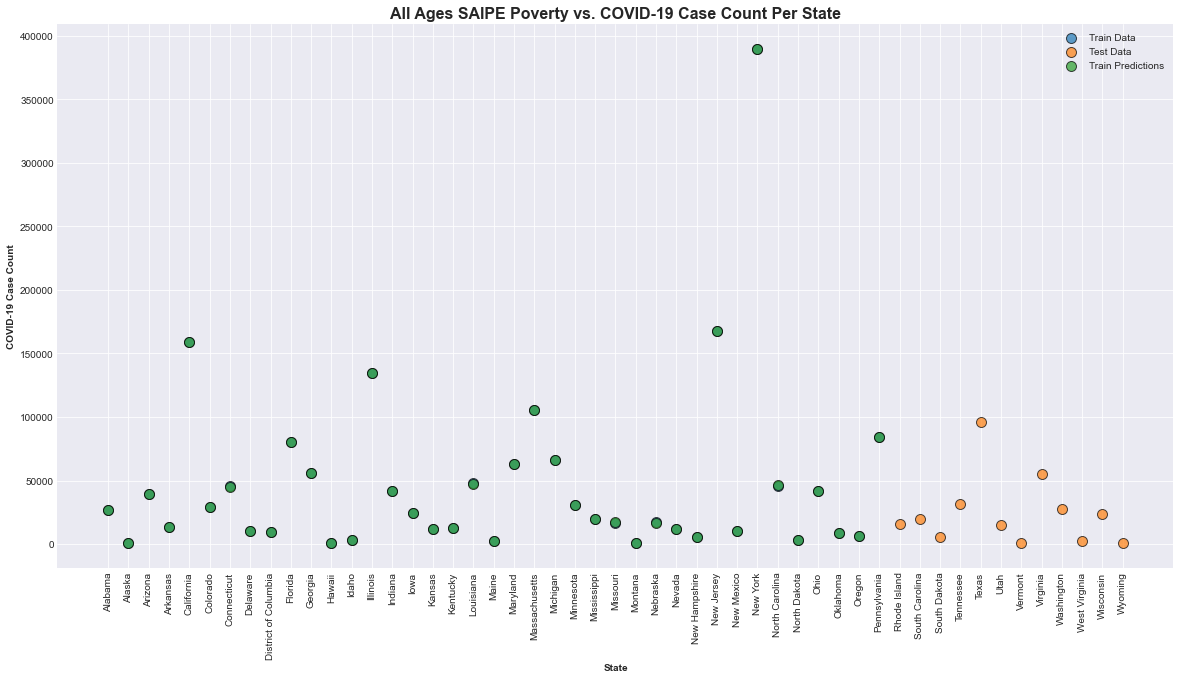

In [10]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('All Ages SAIPE Poverty vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

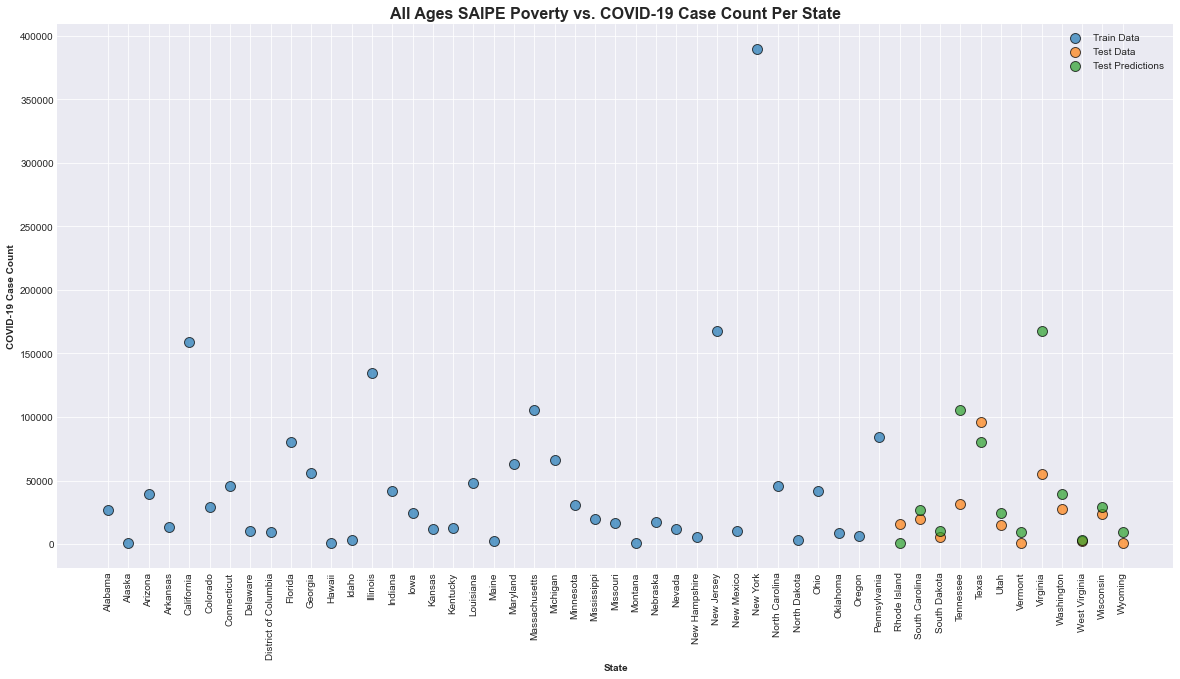

In [11]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('All Ages SAIPE Poverty vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [12]:
evaluate(XGBmodel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.8308 degrees.
Accuracy = 91.23%.


91.2268131829313

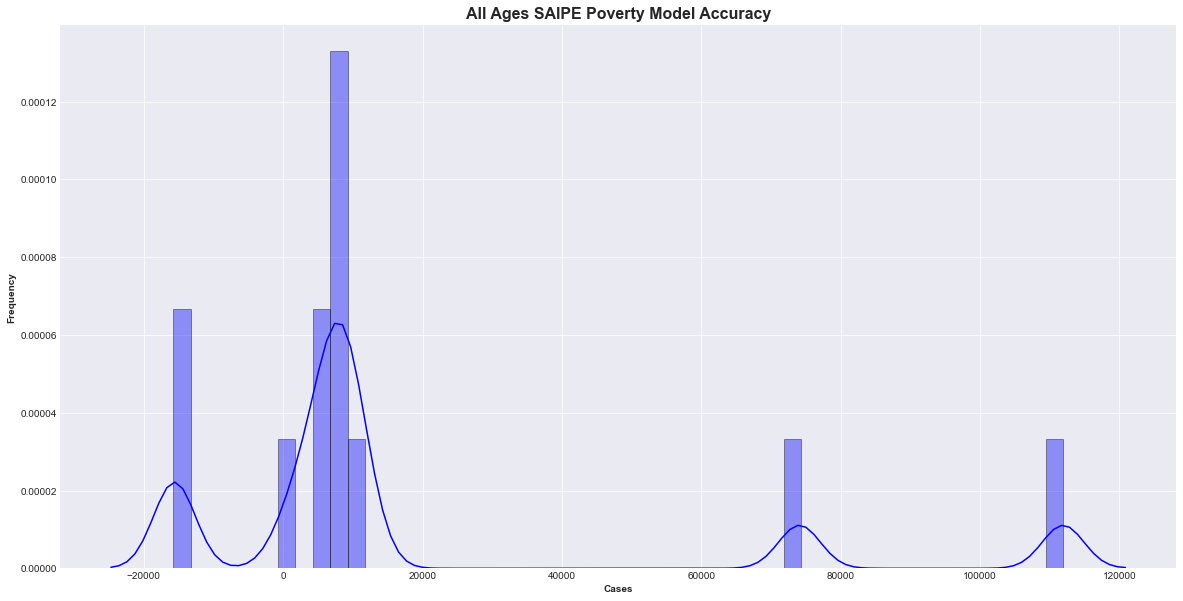

In [13]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('All Ages SAIPE Poverty Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

### Tuning

In [14]:
param_grid = {
    "learning_rate": [0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
    "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "reg_lambda": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "colsample_bytree":[0.7, 0.8, 0.9, 1.0],
    "min_child_weight": [1, 2, 3]
}

kfold = KFold(n_splits = 7)

XG_GridModel = GridSearchCV(estimator = XGBmodel, param_grid = param_grid, 
                          cv = kfold, n_jobs = -1, verbose = 2, return_train_score=True)

XG_NewModel = XG_GridModel.fit(X_train_scaled, y_train_scaled);

Fitting 7 folds for each of 7200 candidates, totalling 50400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 3257 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done 4877 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done 5808 tasks      | elapsed: 19.1min
[Parallel(n_jobs=-1)]: Done 6821 tasks      | elapsed: 21.8min
[Parallel(n_jobs=-1)]: Done 7914 tasks      | elapsed: 25.4min
[Parallel(n_jobs=-1)]: Done 9089 tasks      | 

In [15]:
XG_NewModel.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.05,
 'max_depth': 1,
 'min_child_weight': 3,
 'reg_lambda': 10}

In [16]:
train_predictions_scaled = XG_NewModel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XG_NewModel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 21260.326822916668
Train MSE Value: 1943193563.4813318
Train RMS Value: 44081.66924563238
Train R2 Score: 0.5984988561875777


Test MAE Value: 20337.288736979168
Test MSE Value: 738707422.9669977
Test RMS Value: 27179.172595334792
Test R2 Score: -0.07709947110102577


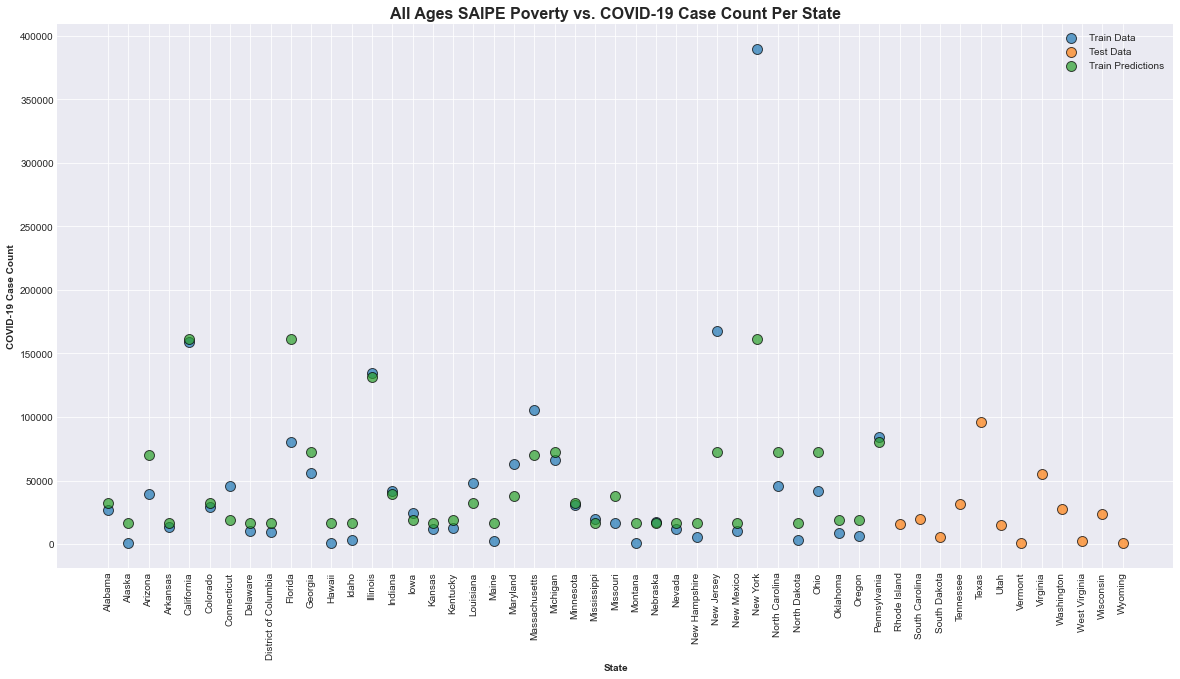

In [17]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('All Ages SAIPE Poverty vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

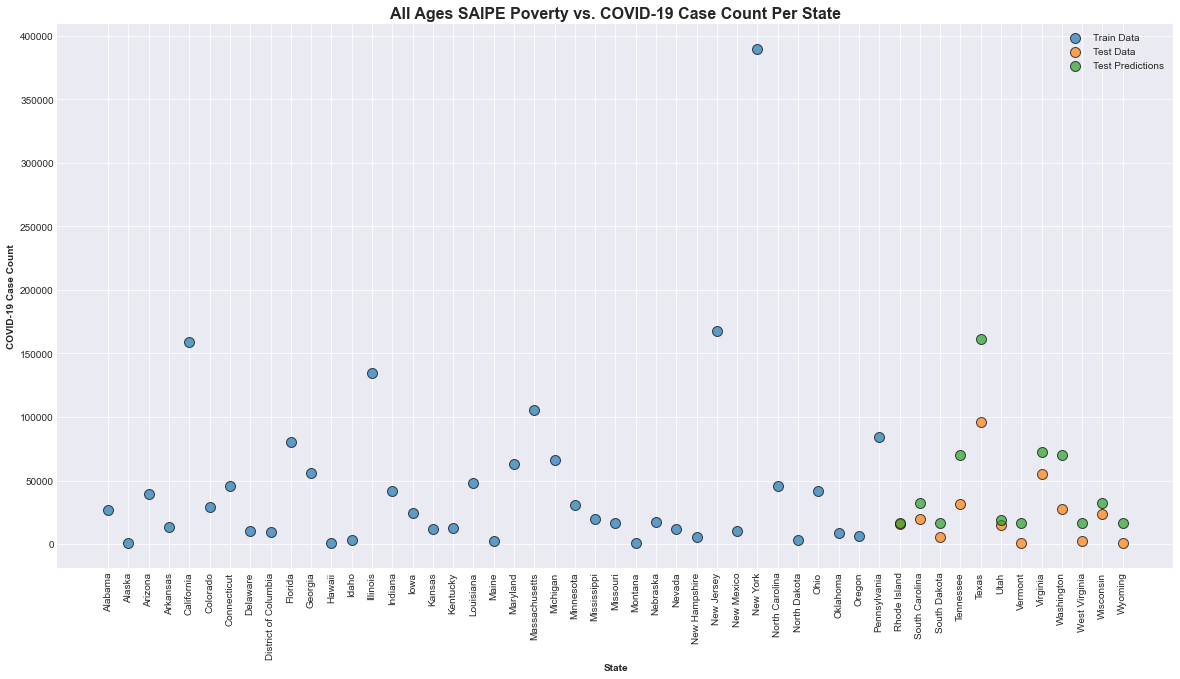

In [18]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('All Ages SAIPE Poverty vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [19]:
base_accuracy = evaluate(XGBmodel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.8308 degrees.
Accuracy = 91.23%.


In [20]:
new_accuracy = evaluate(XG_NewModel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.7305 degrees.
Accuracy = 93.77%.


In [21]:
print('Improvement of {:0.2f}%.'.format( 100 * (new_accuracy - base_accuracy) / new_accuracy))

Improvement of 2.71%.


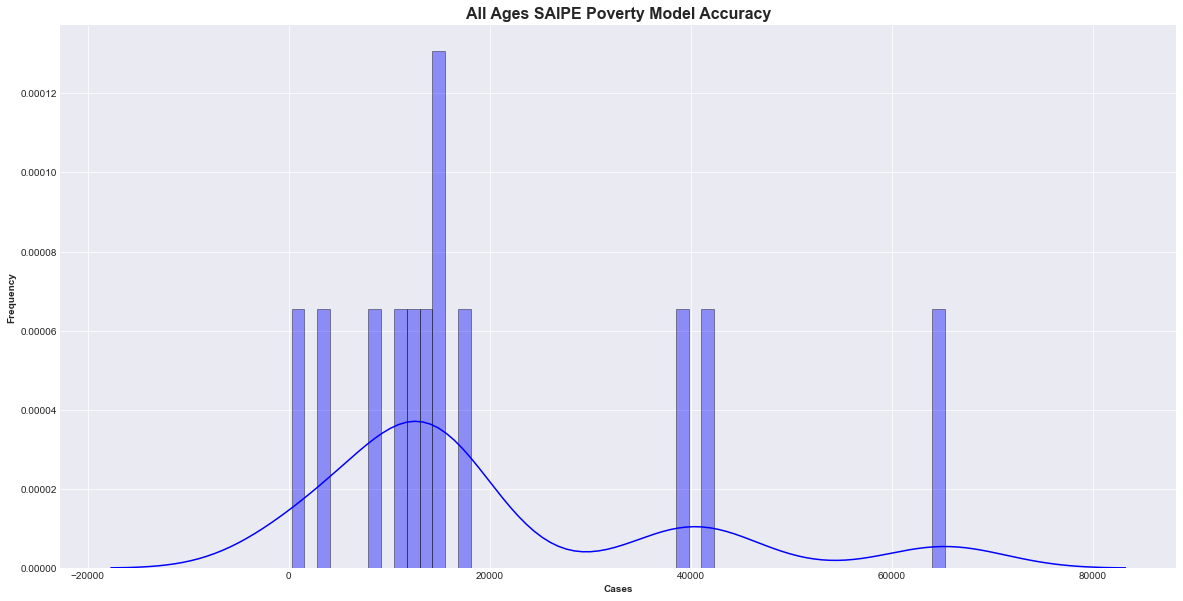

In [22]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('All Ages SAIPE Poverty Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

## All Ages in Poverty Count

In [23]:
features_list = ['All Ages in Poverty Count']

target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))

XGBmodel = XGBRegressor()
XGBmodel.fit(X_train_scaled, y_train_scaled)

train_predictions_scaled = XGBmodel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XGBmodel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 109.67587671524439
Train MSE Value: 18825.55174292003
Train RMS Value: 137.20623798836564
Train R2 Score: 0.9999961102791304


Test MAE Value: 12232.611963907877
Test MSE Value: 402885855.5103349
Test RMS Value: 20072.01672753226
Test R2 Score: 0.4125574911088271


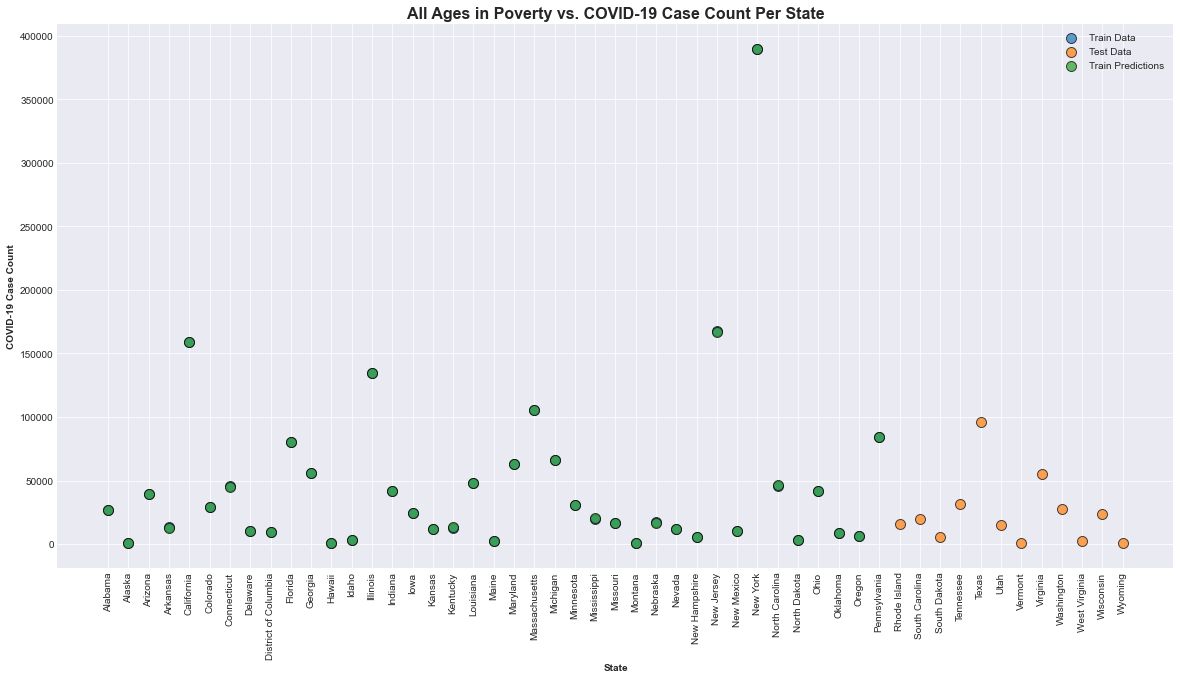

In [24]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('All Ages in Poverty vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

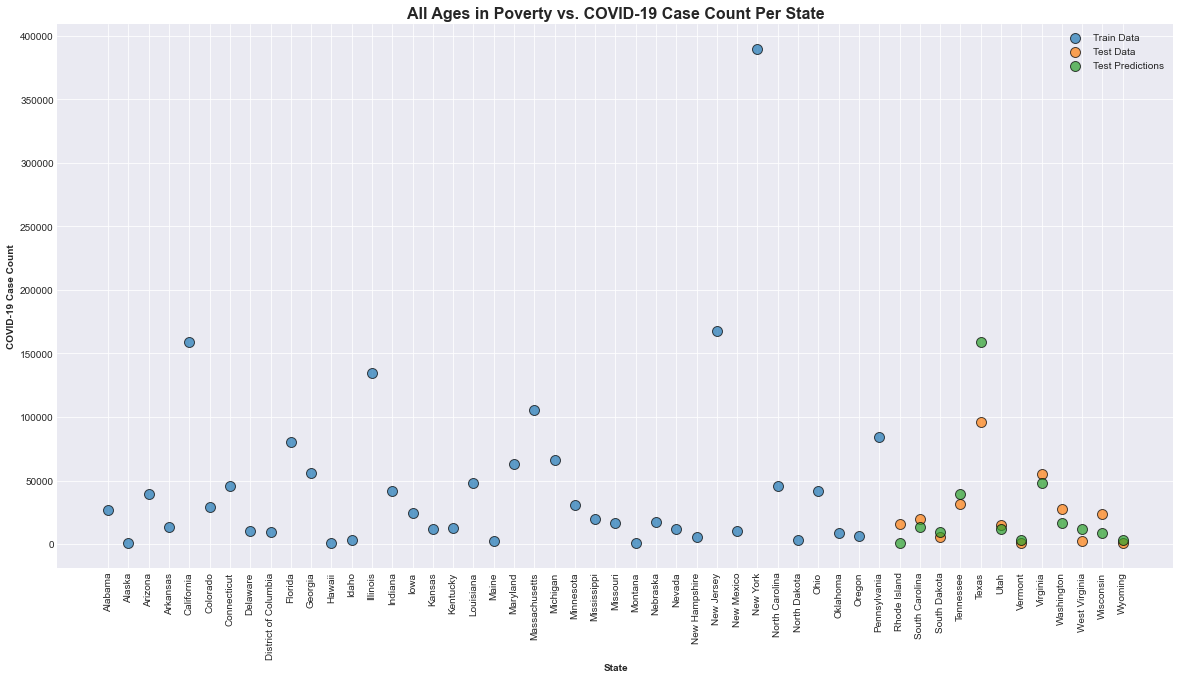

In [25]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('All Ages in Poverty vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [26]:
evaluate(XGBmodel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.8306 degrees.
Accuracy = 91.27%.


91.2720088171514

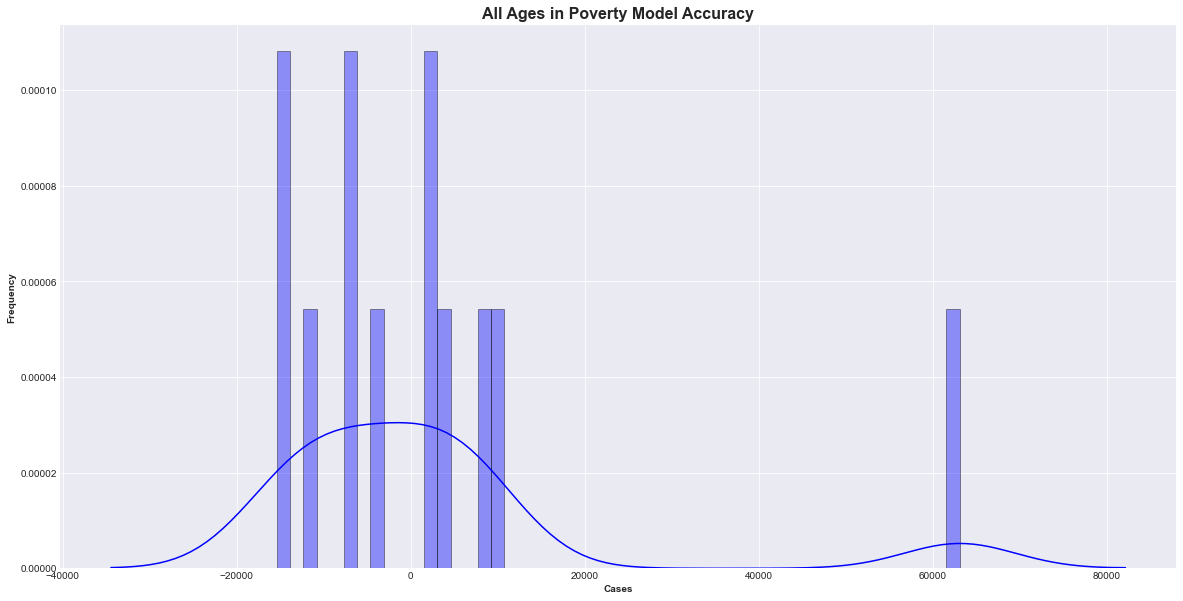

In [27]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('All Ages in Poverty Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

### Tuning

In [28]:
param_grid = {
    "learning_rate": [0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
    "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "reg_lambda": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "colsample_bytree":[0.7, 0.8, 0.9, 1.0],
    "min_child_weight": [1, 2, 3]
}

kfold = KFold(n_splits = 7)

XG_GridModel = GridSearchCV(estimator = XGBmodel, param_grid = param_grid, 
                          cv = kfold, n_jobs = -1, verbose = 2, return_train_score=True)

XG_NewModel = XG_GridModel.fit(X_train_scaled, y_train_scaled);

Fitting 7 folds for each of 7200 candidates, totalling 50400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 1954 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 2844 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 3898 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 5112 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 6490 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done 8028 tasks      | elapsed:   51.3s
[Parallel(n_jobs=-1)]: Done 9730 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 11592 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 13618 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 15804 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 18154 tasks  

In [29]:
XG_NewModel.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.05,
 'max_depth': 8,
 'min_child_weight': 1,
 'reg_lambda': 10}

In [30]:
train_predictions_scaled = XG_NewModel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XG_NewModel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 16871.61668669872
Train MSE Value: 1269486750.0340767
Train RMS Value: 35629.857564044185
Train R2 Score: 0.737699634368775


Test MAE Value: 9492.975748697916
Test MSE Value: 152309330.14436755
Test RMS Value: 12341.366623853597
Test R2 Score: 0.7779197909189293


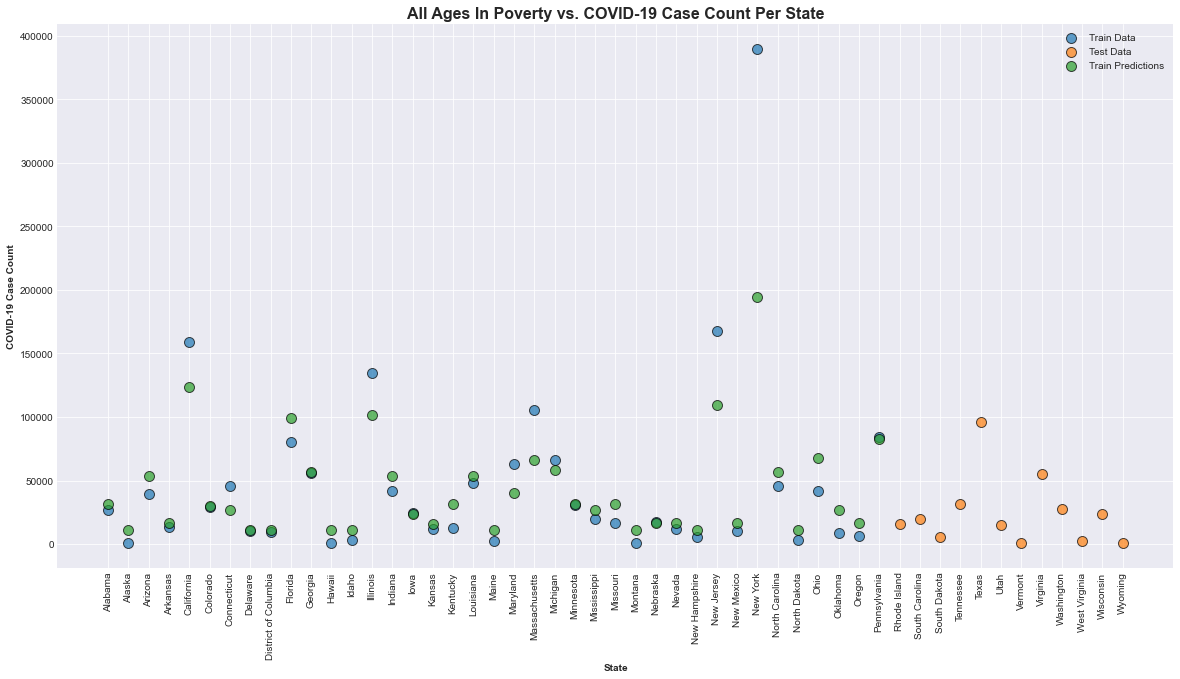

In [31]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('All Ages In Poverty vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

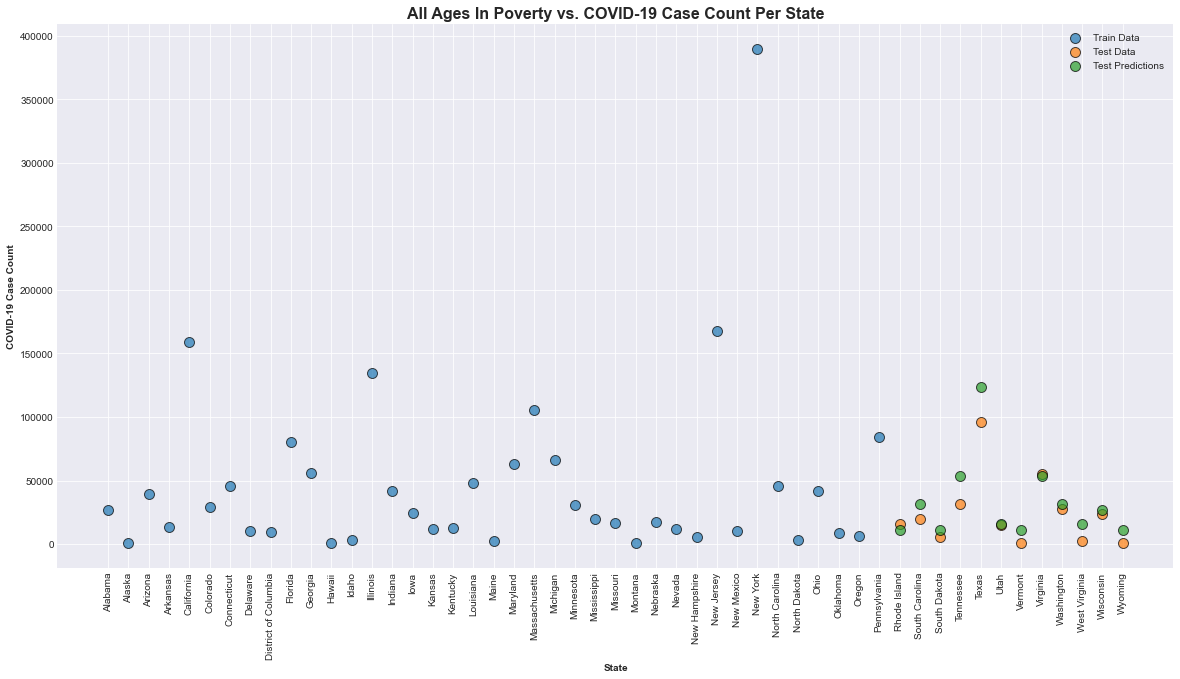

In [32]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('All Ages In Poverty vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [33]:
base_accuracy = evaluate(XGBmodel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.8306 degrees.
Accuracy = 91.27%.


In [34]:
new_accuracy = evaluate(XG_NewModel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.7063 degrees.
Accuracy = 94.90%.


In [35]:
print('Improvement of {:0.2f}%.'.format( 100 * (new_accuracy - base_accuracy) / new_accuracy))

Improvement of 3.82%.


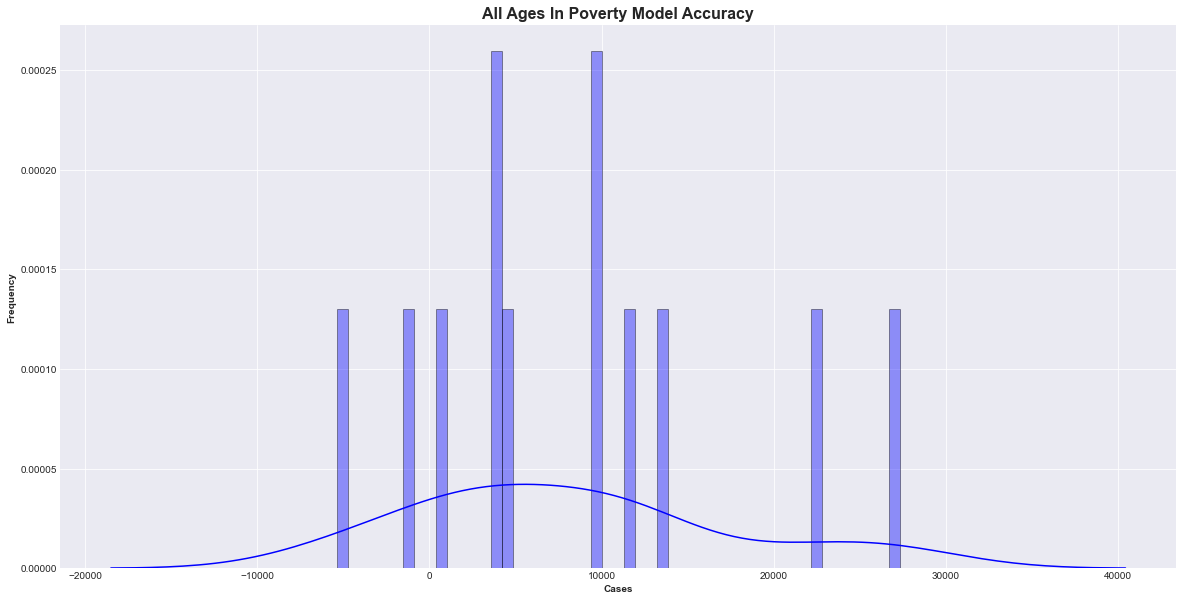

In [36]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('All Ages In Poverty Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

## Overall Poverty

In [38]:
features_list = ['All Ages SAIPE Poverty Universe','All Ages in Poverty Count']

target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))

XGBmodel = XGBRegressor()
XGBmodel.fit(X_train_scaled, y_train_scaled)

train_predictions_scaled = XGBmodel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XGBmodel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 89.73554718800081
Train MSE Value: 12452.611656812043
Train RMS Value: 111.59127052243846
Train R2 Score: 0.9999974270510578


Test MAE Value: 18284.077356974285
Test MSE Value: 1078732724.2051485
Test RMS Value: 32844.06680368843
Test R2 Score: -0.5728858416421283


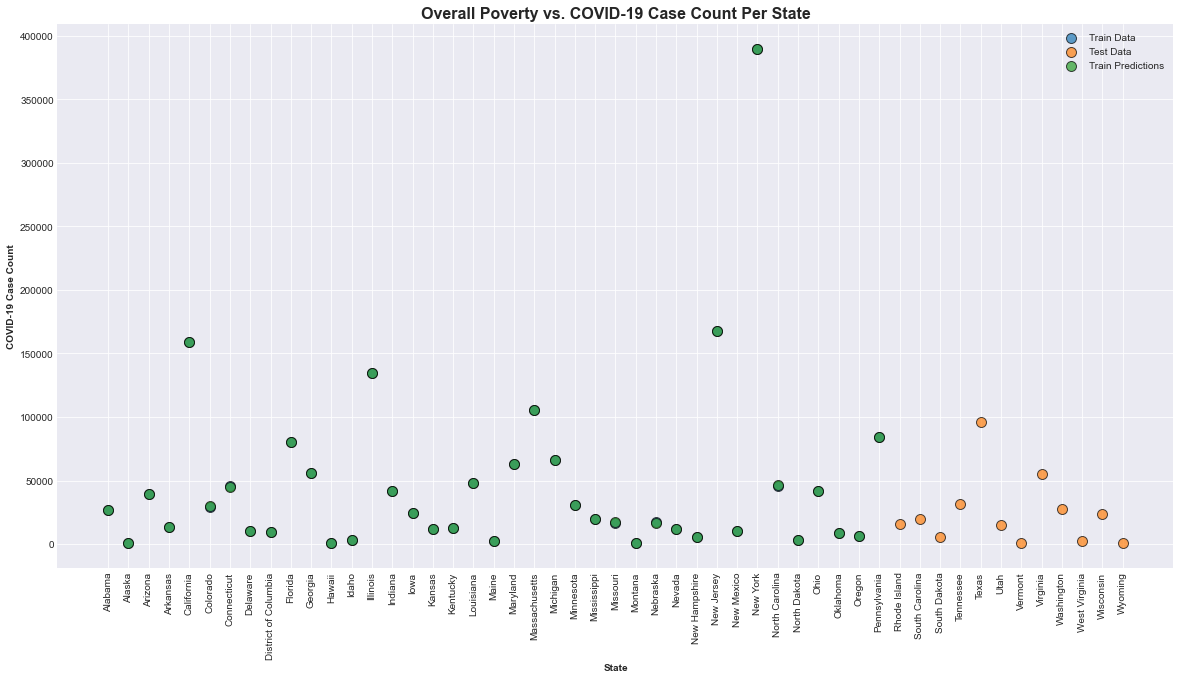

In [39]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Overall Poverty vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

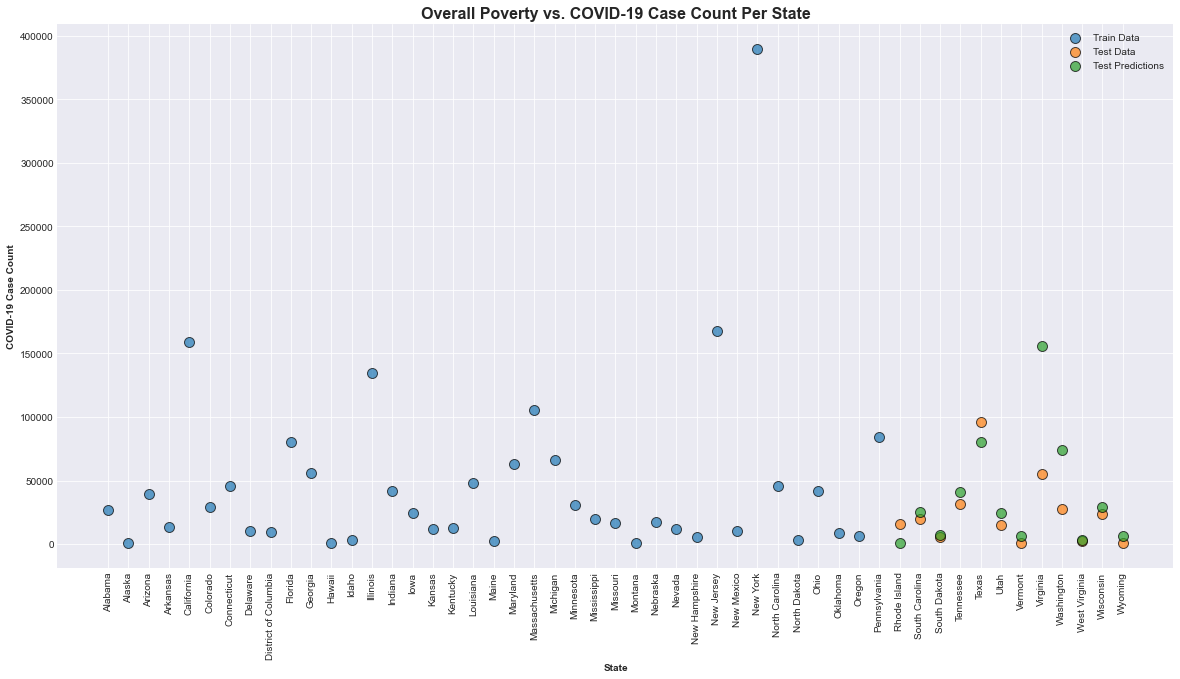

In [40]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Overall Poverty vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [41]:
evaluate(XGBmodel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.8309 degrees.
Accuracy = 91.28%.


91.28062642773007

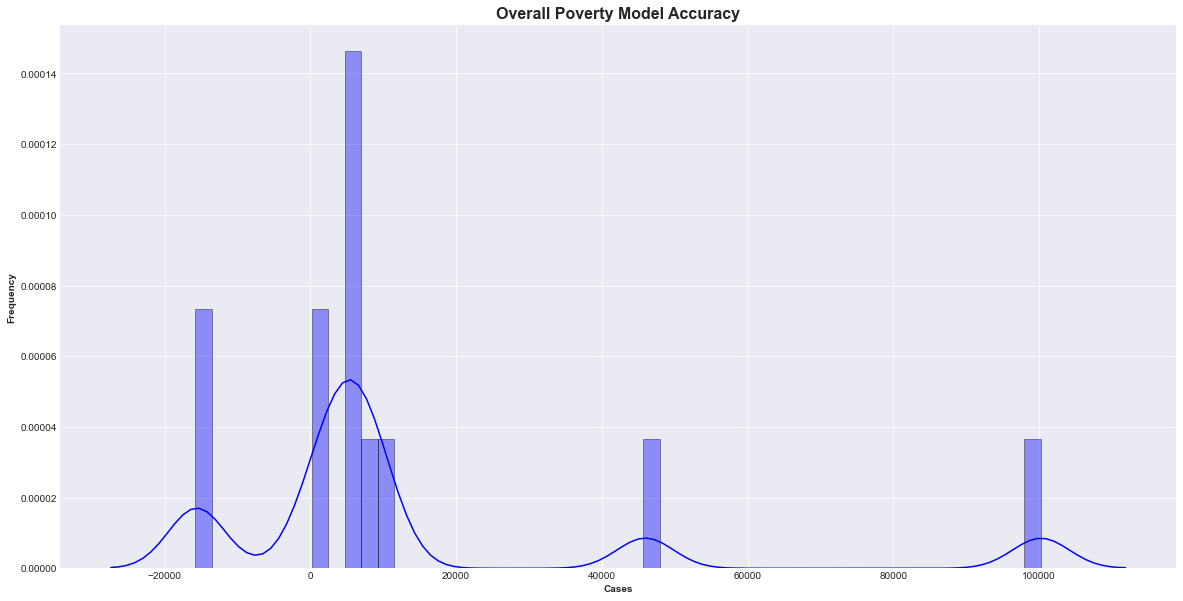

In [42]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('Overall Poverty Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

### Tuning

In [43]:
param_grid = {
    "learning_rate": [0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
    "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "reg_lambda": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "colsample_bytree":[0.7, 0.8, 0.9, 1.0],
    "min_child_weight": [1, 2, 3]
}

kfold = KFold(n_splits = 7)

XG_GridModel = GridSearchCV(estimator = XGBmodel, param_grid = param_grid, 
                          cv = kfold, n_jobs = -1, verbose = 2, return_train_score=True)

XG_NewModel = XG_GridModel.fit(X_train_scaled, y_train_scaled);

Fitting 7 folds for each of 7200 candidates, totalling 50400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:   41.0s
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 3257 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 4877 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 5808 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 6821 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 7914 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 9089 tasks      | 

In [44]:
XG_NewModel.best_params_

{'colsample_bytree': 1.0,
 'learning_rate': 0.05,
 'max_depth': 1,
 'min_child_weight': 3,
 'reg_lambda': 10}

In [45]:
train_predictions_scaled = XG_NewModel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XG_NewModel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 21260.326822916668
Train MSE Value: 1943193563.4813318
Train RMS Value: 44081.66924563238
Train R2 Score: 0.5984988561875777


Test MAE Value: 20337.288736979168
Test MSE Value: 738707422.9669977
Test RMS Value: 27179.172595334792
Test R2 Score: -0.07709947110102577


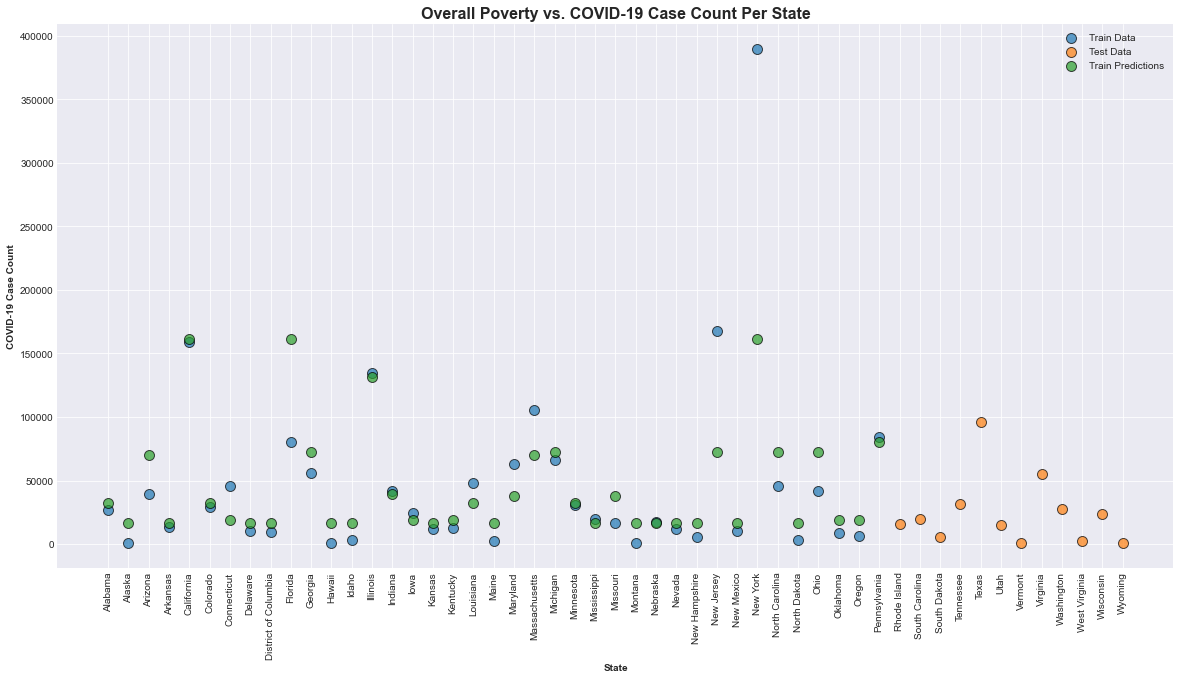

In [46]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Overall Poverty vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

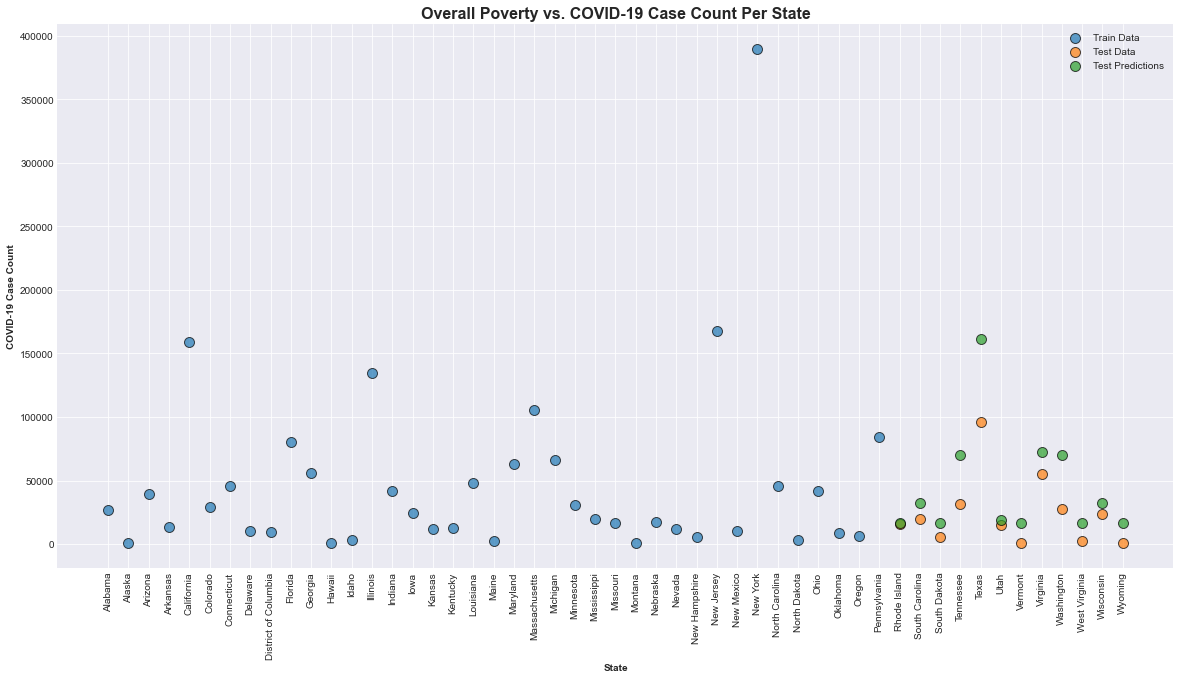

In [47]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Overall Poverty vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [48]:
base_accuracy = evaluate(XGBmodel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.8309 degrees.
Accuracy = 91.28%.


In [49]:
new_accuracy = evaluate(XG_NewModel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.7305 degrees.
Accuracy = 93.77%.


In [50]:
print('Improvement of {:0.2f}%.'.format( 100 * (new_accuracy - base_accuracy) / new_accuracy))

Improvement of 2.66%.


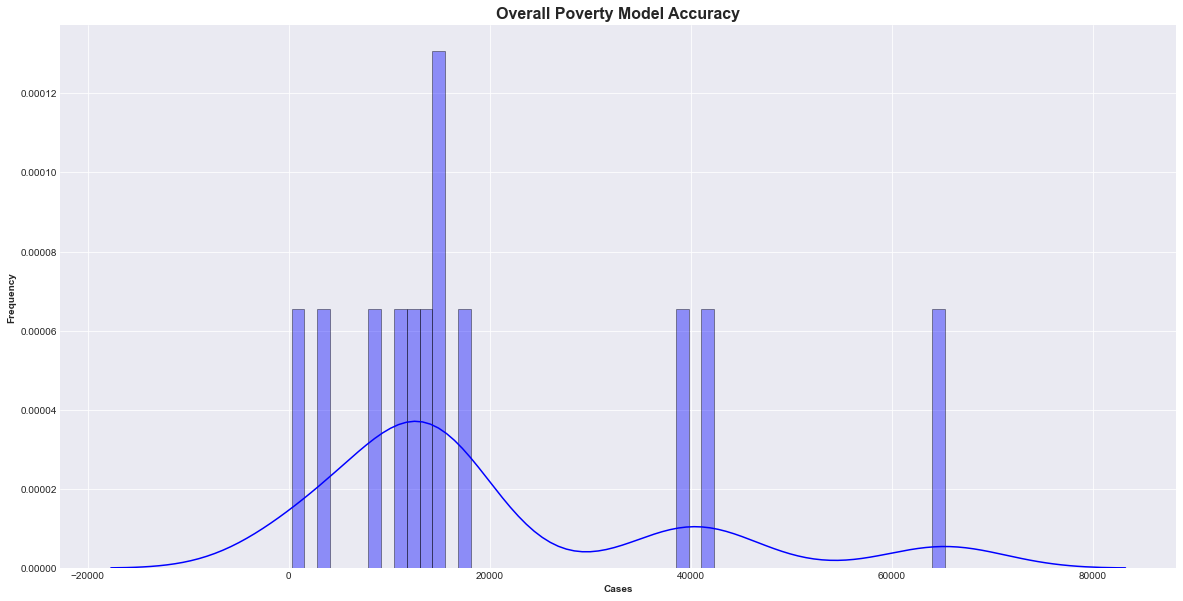

In [51]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('Overall Poverty Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();